<img align="left" src="https://lever-client-logos.s3.amazonaws.com/864372b1-534c-480e-acd5-9711f850815c-1524247202159.png" width=200>
<br></br>
<br></br>

# Natural Language Processing (NLP)
## *Data Science Unit 4 Sprint 1 Assignment 1*

Your goal in this assignment: find the attributes of the best & worst coffee shops in the dataset. The text is fairly raw: dates in the review, extra words in the `star_rating` column, etc. You'll probably want to clean that stuff up for a better analysis. 

Analyze the corpus of text using text visualizations of token frequency. Try cleaning the data as much as possible. Try the following techniques: 
- Lemmatization
- Custom stopword removal

Keep in mind the attributes of good tokens. Once you have a solid baseline, layer in the star rating in your visualization(s). Key part of this assignment - produce a write-up of the attributes of the best and worst coffee shops. Based on your analysis, what makes the best the best and the worst the worst. Use graphs and numbesr from your analysis to support your conclusions. There should be plenty of markdown cells! :coffee:

In [1]:
from IPython.display import YouTubeVideo

YouTubeVideo('Jml7NVYm8cs')

In [2]:
%pwd

'/home/tmbern/workspace/repos/lambda/DS-Unit-4-Sprint-1-NLP/module1-text-data'

In [21]:
import pandas as pd

url = "https://raw.githubusercontent.com/tmbern/DS-Unit-4-Sprint-1-NLP/master/module1-text-data/data/yelp_coffeeshop_review_data.csv"

shops = pd.read_csv(url)
print(shops.shape)
shops.head()

(7616, 3)


,coffee_shop_name,full_review_text,star_rating
0,The Factory - Cafe With a Soul,11/25/2016 1 check-in Love love loved the atm...,5.0 star rating
1,The Factory - Cafe With a Soul,"12/2/2016 Listed in Date Night: Austin, Ambia...",4.0 star rating
2,The Factory - Cafe With a Soul,11/30/2016 1 check-in Listed in Brunch Spots ...,4.0 star rating
3,The Factory - Cafe With a Soul,11/25/2016 Very cool decor! Good drinks Nice ...,2.0 star rating
4,The Factory - Cafe With a Soul,12/3/2016 1 check-in They are located within ...,4.0 star rating


In [28]:
# Start here 
import re
text = shops['full_review_text'][0]
sample_token = re.sub('[^a-zA-Z 0-9]', '', text)
sample_token

' 11252016 1 checkin Love love loved the atmosphere Every corner of the coffee shop had its own style and there were swings I ordered the matcha latte and it was muy fantastico Ordering and getting my drink were pretty streamlined I ordered on an iPad which included all beverage selections that ranged from coffee to wine desired level of sweetness and a checkout system I got my latte within minutes  I was hoping for a typical heart or feather on my latte but found myself listing out all the possibilities of what the art may be Any ideas '

## How do we want to analyze these coffee shop tokens? 

- Overall Word / Token Count
- View Counts by Rating 
- *Hint:* a 'bad' coffee shops has a rating betweeen 1 & 3 based on the distribution of ratings. A 'good' coffee shop is a 4 or 5. 

In [22]:
# overall word/token Count

# create a tokenizer
import spacy
from spacy.tokenizer import Tokenizer

nlp = spacy.load("en_core_web_lg")

tokenizer = Tokenizer(nlp.vocab)

In [23]:
# Tokenizer pipe 

tokens = []

for doc in tokenizer.pipe(shops['full_review_text'], batch_size=500):
    doc_tokens = [token.text for token in doc]
    tokens.append(doc_tokens)

shops['tokens'] = tokens

In [24]:
shops.head()

,coffee_shop_name,full_review_text,star_rating,tokens
0,The Factory - Cafe With a Soul,11/25/2016 1 check-in Love love loved the atm...,5.0 star rating,"[ , 11/25/2016, 1, check-in, Love, love, loved..."
1,The Factory - Cafe With a Soul,"12/2/2016 Listed in Date Night: Austin, Ambia...",4.0 star rating,"[ , 12/2/2016, Listed, in, Date, Night:, Austi..."
2,The Factory - Cafe With a Soul,11/30/2016 1 check-in Listed in Brunch Spots ...,4.0 star rating,"[ , 11/30/2016, 1, check-in, Listed, in, Brunc..."
3,The Factory - Cafe With a Soul,11/25/2016 Very cool decor! Good drinks Nice ...,2.0 star rating,"[ , 11/25/2016, Very, cool, decor!, Good, drin..."
4,The Factory - Cafe With a Soul,12/3/2016 1 check-in They are located within ...,4.0 star rating,"[ , 12/3/2016, 1, check-in, They, are, located..."


In [43]:
# get a rating as a float so we can filter on good (4-5) and bad (1-3)

rating = lambda x: float(x[:4].strip())
shops['star_rating_floats'] = shops['star_rating'].apply(rating)
shops.head()

,coffee_shop_name,full_review_text,star_rating,tokens,star_rating_floats
0,The Factory - Cafe With a Soul,11/25/2016 1 check-in Love love loved the atm...,5.0 star rating,"[ , 11/25/2016, 1, check-in, Love, love, loved...",5.0
1,The Factory - Cafe With a Soul,"12/2/2016 Listed in Date Night: Austin, Ambia...",4.0 star rating,"[ , 12/2/2016, Listed, in, Date, Night:, Austi...",4.0
2,The Factory - Cafe With a Soul,11/30/2016 1 check-in Listed in Brunch Spots ...,4.0 star rating,"[ , 11/30/2016, 1, check-in, Listed, in, Brunc...",4.0
3,The Factory - Cafe With a Soul,11/25/2016 Very cool decor! Good drinks Nice ...,2.0 star rating,"[ , 11/25/2016, Very, cool, decor!, Good, drin...",2.0
4,The Factory - Cafe With a Soul,12/3/2016 1 check-in They are located within ...,4.0 star rating,"[ , 12/3/2016, 1, check-in, They, are, located...",4.0


In [18]:
from collections import Counter

def count(docs):

        word_counts = Counter()
        appears_in = Counter()
        
        total_docs = len(docs)

        for doc in docs:
            word_counts.update(doc)
            appears_in.update(set(doc))

        temp = zip(word_counts.keys(), word_counts.values())
        
        wc = pd.DataFrame(temp, columns = ['word', 'count'])

        wc['rank'] = wc['count'].rank(method='first', ascending=False)
        total = wc['count'].sum()

        wc['pct_total'] = wc['count'].apply(lambda x: x / total)
        
        wc = wc.sort_values(by='rank')
        wc['cul_pct_total'] = wc['pct_total'].cumsum()

        t2 = zip(appears_in.keys(), appears_in.values())
        ac = pd.DataFrame(t2, columns=['word', 'appears_in'])
        wc = ac.merge(wc, on='word')

        wc['appears_in_pct'] = wc['appears_in'].apply(lambda x: x / total_docs)
        
        return wc.sort_values(by='rank')

In [45]:
word_counts = count(shops['tokens'])
word_counts.head()

,word,appears_in,count,rank,pct_total,cul_pct_total,appears_in_pct
21,the,6520,27779,1.0,0.034334,0.034334,0.856092
34,and,6804,25748,2.0,0.031824,0.066157,0.893382
41,,7616,22606,3.0,0.027940,0.094097,1.000000
10,a,6181,22085,4.0,0.027296,0.121394,0.811581
15,I,5469,19780,5.0,0.024447,0.145841,0.718093


## Add stop words to get a better representation

In [20]:
# we need to add stop words now to get a better representation.
nlp.Defaults.stop_words


{"'d",
 "'ll",
 "'m",
 "'re",
 "'s",
 "'ve",
 'a',
 'about',
 'above',
 'across',
 'after',
 'afterwards',
 'again',
 'against',
 'all',
 'almost',
 'alone',
 'along',
 'already',
 'also',
 'although',
 'always',
 'am',
 'among',
 'amongst',
 'amount',
 'an',
 'and',
 'another',
 'any',
 'anyhow',
 'anyone',
 'anything',
 'anyway',
 'anywhere',
 'are',
 'around',
 'as',
 'at',
 'back',
 'be',
 'became',
 'because',
 'become',
 'becomes',
 'becoming',
 'been',
 'before',
 'beforehand',
 'behind',
 'being',
 'below',
 'beside',
 'besides',
 'between',
 'beyond',
 'both',
 'bottom',
 'but',
 'by',
 'ca',
 'call',
 'can',
 'cannot',
 'could',
 'did',
 'do',
 'does',
 'doing',
 'done',
 'down',
 'due',
 'during',
 'each',
 'eight',
 'either',
 'eleven',
 'else',
 'elsewhere',
 'empty',
 'enough',
 'even',
 'ever',
 'every',
 'everyone',
 'everything',
 'everywhere',
 'except',
 'few',
 'fifteen',
 'fifty',
 'first',
 'five',
 'for',
 'former',
 'formerly',
 'forty',
 'four',
 'from',
 'fron

In [47]:
# update the tokens to not include stop words

tokens = []

for doc in tokenizer.pipe(shops['full_review_text'], batch_size=500):
    
    doc_tokens = []
    
    for token in doc:
        if (token.is_stop ==False) & (token.is_punct == False):
            doc_tokens.append(token.text.lower())
            
    tokens.append(doc_tokens)

shops['tokens'] = tokens

In [70]:
# get the wordcount for the new tokens without stop words

word_counts = count(shops['tokens'])
word_counts.sort_values(by='pct_total', ascending=False).head(15)

,word,appears_in,count,rank,pct_total,cul_pct_total,appears_in_pct
31,coffee,4210,8058,1.0,0.020917,0.020917,0.552784
72,great,2438,3250,2.0,0.008436,0.029353,0.320116
175,like,2034,2902,3.0,0.007533,0.036886,0.267069
177,good,2084,2779,4.0,0.007214,0.044100,0.273634
4,love,1434,1806,5.0,0.004688,0.048788,0.188288
799,little,1230,1479,6.0,0.003839,0.052627,0.161502
384,don't,1133,1395,7.0,0.003621,0.056248,0.148766
173,nice,1188,1368,8.0,0.003551,0.059799,0.155987
477,food,1092,1363,9.0,0.003538,0.063337,0.143382
627,time,1099,1345,10.0,0.003491,0.066828,0.144301


In [50]:
# looks like there are more stop words that we can add to make it better...'it's', '1', 'check-in', 'i'm'...

STOP_WORDS = nlp.Defaults.stop_words.union(['place', "'it's", '1', 'check-in', "i'm", "i've", " "])

In [54]:
# get the new tokens without the new stop words
tokens = []

for doc in tokenizer.pipe(shops['full_review_text'], batch_size=500):
    
    doc_tokens = []
    
    for token in doc: 
        if token.text.lower() not in STOP_WORDS:
            doc_tokens.append(token.text.lower())
   
    tokens.append(doc_tokens)
    
shops['tokens'] = tokens

In [55]:
# get the new word counts
word_counts = count(shops['tokens'])
word_counts.head(15)


,word,appears_in,count,rank,pct_total,cul_pct_total,appears_in_pct
32,coffee,4210,8058,1.0,0.020589,0.020589,0.552784
73,great,2438,3250,2.0,0.008304,0.028893,0.320116
286,it's,2061,3117,3.0,0.007964,0.036857,0.270614
177,like,2034,2902,4.0,0.007415,0.044272,0.267069
179,good,2084,2779,5.0,0.007101,0.051372,0.273634
4,love,1434,1806,6.0,0.004614,0.055987,0.188288
129,-,919,1773,7.0,0.004530,0.060517,0.120667
802,little,1230,1479,8.0,0.003779,0.064296,0.161502
387,don't,1133,1395,9.0,0.003564,0.067860,0.148766
175,nice,1188,1368,10.0,0.003495,0.071355,0.155987


In [59]:
# there are still a lot of words in here that dont really apply. Maybe we should do some Lemmatization

# function to get lemmas of text
def get_lemmas(text):

    lemmas = []
    
    doc = nlp(text)
    
    # Something goes here :P
    for token in doc: 
        if (token.text.lower() not in STOP_WORDS) & (token.is_punct == False) & (token.pos_ != 'PRON'):
            lemmas.append(token.lemma_)
    
    return lemmas

In [60]:
shops['lemmas'] = shops['full_review_text'].apply(get_lemmas)

In [62]:
# get the new word counts
word_counts = count(shops['tokens'])
word_counts.head(15)

,word,appears_in,count,rank,pct_total,cul_pct_total,appears_in_pct
32,coffee,4210,8058,1.0,0.020589,0.020589,0.552784
73,great,2438,3250,2.0,0.008304,0.028893,0.320116
286,it's,2061,3117,3.0,0.007964,0.036857,0.270614
177,like,2034,2902,4.0,0.007415,0.044272,0.267069
179,good,2084,2779,5.0,0.007101,0.051372,0.273634
4,love,1434,1806,6.0,0.004614,0.055987,0.188288
129,-,919,1773,7.0,0.004530,0.060517,0.120667
802,little,1230,1479,8.0,0.003779,0.064296,0.161502
387,don't,1133,1395,9.0,0.003564,0.067860,0.148766
175,nice,1188,1368,10.0,0.003495,0.071355,0.155987


In [74]:
# we still have a lot of words that dont necissarily feel like the belong... "-", 'got', 'it's', 'coffee', 'Austin'

STOP_WORDS = nlp.Defaults.stop_words.union(['place', "it's", '1', 'check-in', "i'm", "i've", " ", "-", "got", 'coffee', 'austin'])

In [75]:
# get the new tokens without the new stop words
tokens = []

for doc in tokenizer.pipe(shops['full_review_text'], batch_size=500):
    
    doc_tokens = []
    
    for token in doc: 
        if token.text.lower() not in STOP_WORDS:
            doc_tokens.append(token.text.lower())
   
    tokens.append(doc_tokens)
    
shops['tokens'] = tokens

In [76]:
# get the new word counts
word_counts = count(shops['tokens'])
word_counts.head(15)

,word,appears_in,count,rank,pct_total,cul_pct_total,appears_in_pct
70,great,2438,3250,1.0,0.008644,0.008644,0.320116
173,like,2034,2902,2.0,0.007718,0.016362,0.267069
175,good,2084,2779,3.0,0.007391,0.023753,0.273634
4,love,1434,1806,4.0,0.004803,0.028556,0.188288
797,little,1230,1479,5.0,0.003934,0.032490,0.161502
382,don't,1133,1395,6.0,0.003710,0.036200,0.148766
171,nice,1188,1368,7.0,0.003638,0.039838,0.155987
475,food,1092,1363,8.0,0.003625,0.043463,0.143382
625,time,1099,1345,9.0,0.003577,0.047040,0.144301
39,pretty,1066,1339,10.0,0.003561,0.050602,0.139968


## Can visualize the words with the greatest difference in counts between 'good' & 'bad'?

Couple Notes: 
- Rel. freq. instead of absolute counts b/c of different numbers of reviews
- Only look at the top 5-10 words with the greatest differences


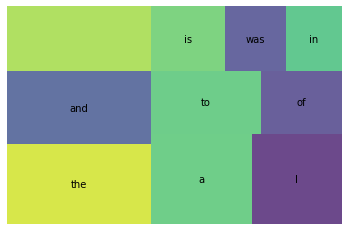

In [44]:
# visualize before stop words are taken into consideration

import squarify
import matplotlib.pyplot as plt

wc_top10 = word_counts[word_counts['rank'] <= 10]

squarify.plot(sizes=wc_top10['pct_total'], label=wc_top10['word'], alpha=.8)
plt.axis('off')
plt.show()

In [82]:
# lets split our dataframe into two subsets... one for good (4-5 rating) and one for bad (1-3 rating)

good_ratings = shops[shops['star_rating_floats'] >= 4]
bad_ratings = shops[shops['star_rating_floats'] <= 3]

In [83]:
# get the word counts for the good ratings

good_wc = count(good_ratings['tokens'])
good_wc.head(15)

,word,appears_in,count,rank,pct_total,cul_pct_total,appears_in_pct
70,great,2174,2902,1.0,0.009922,0.009922,0.354072
263,good,1643,2180,2.0,0.007453,0.017375,0.267590
234,like,1486,2068,3.0,0.007070,0.024445,0.242020
4,love,1263,1604,4.0,0.005484,0.029929,0.205700
607,little,1027,1230,5.0,0.004205,0.034134,0.167264
230,nice,962,1101,6.0,0.003764,0.037898,0.156678
441,best,951,1093,7.0,0.003737,0.041635,0.154886
197,friendly,986,1014,8.0,0.003467,0.045102,0.160586
59,definitely,889,1002,9.0,0.003426,0.048528,0.144788
449,food,826,994,10.0,0.003398,0.051926,0.134528


In [84]:
# get the word counts for the bad ratings

bad_wc = count(bad_ratings['tokens'])
bad_wc.head(15)

,word,appears_in,count,rank,pct_total,cul_pct_total,appears_in_pct
19,like,548,834,1.0,0.009988,0.009988,0.371274
21,good,441,599,2.0,0.007173,0.017161,0.298780
217,don't,340,430,3.0,0.005149,0.022310,0.230352
171,food,266,369,4.0,0.004419,0.026729,0.180217
250,time,264,351,5.0,0.004203,0.030933,0.178862
76,pretty,278,349,6.0,0.004179,0.035112,0.188347
51,great,264,348,7.0,0.004167,0.039280,0.178862
484,people,247,327,8.0,0.003916,0.043196,0.167344
9,service,261,314,9.0,0.003760,0.046956,0.176829
363,ordered,240,296,10.0,0.003545,0.050501,0.162602


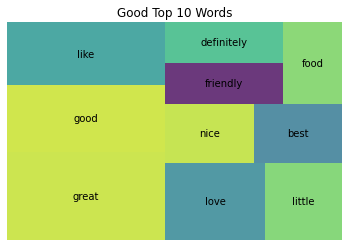

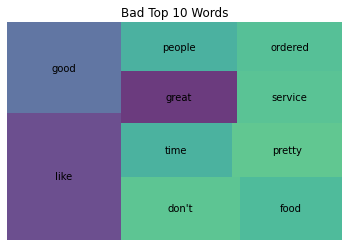

In [92]:
# visualize difference between good and bad ratings

good_top10 = good_wc[good_wc['rank'] <= 10]

squarify.plot(sizes=good_top10['pct_total'], label=good_top10['word'], alpha=.8)
plt.axis('off')
plt.title('Good Top 10 Words')
plt.show()

bad_top10 = bad_wc[bad_wc['rank'] <= 10]

squarify.plot(sizes=bad_top10['pct_total'], label=bad_top10['word'], alpha=.8)
plt.axis('off')
plt.title('Bad Top 10 Words')
plt.show()

## Stretch Goals

* Analyze another corpus of documents - such as Indeed.com job listings ;).
* Play with the Spacy API to
 - Extract Named Entities
 - Extracting 'noun chunks'
 - Attempt Document Classification with just Spacy
 - *Note:* This [course](https://course.spacy.io/) will be of interesting in helping you with these stretch goals. 
* Try to build a plotly dash app with your text data 

